# Notebook for exploring data, testing

In [74]:
import os
import json
from pathlib import Path

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer

# General display options for pandas
pd.set_option('display.max_colwidth', 500)

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


### 0. Loading dataset

In [75]:
# Configuration
DATA_DIR = Path("data/code_classification_dataset/")
OUTPUT_FILE = "data/dataset.parquet" 
PREPROCESSED_OUTPUT_FILE = "data/preprocessed_dataset.parquet" 

def load_json_files(data_dir):
    """
    Load all JSON files from the data directory.
    
    Args:
        data_dir: Path to directory containing JSON files
        
    Returns:
        List of dictionaries containing the data
    """
    all_data = []
    json_files = sorted(data_dir.glob("sample_*.json"))
    
    print(f"Found {len(json_files)} JSON files")
    
    for json_file in json_files:
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                all_data.append(data)
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
    
    return all_data

def convert_to_dataframe(data_list):
    """
    Convert list of dictionaries to pandas DataFrame.
    Handles nested structures and lists.
    
    Args:
        data_list: List of dictionaries
        
    Returns:
        pandas DataFrame
    """
    # Convert lists in sample_inputs/outputs to strings for easier handling
    processed_data = []
    
    for item in data_list:
        processed_item = item.copy()
        
        # Convert list fields to strings or keep as is
        if 'prob_desc_sample_inputs' in processed_item:
            if isinstance(processed_item['prob_desc_sample_inputs'], list):
                processed_item['prob_desc_sample_inputs'] = processed_item['prob_desc_sample_inputs'][0] if processed_item['prob_desc_sample_inputs'] else None
        
        if 'prob_desc_sample_outputs' in processed_item:
            if isinstance(processed_item['prob_desc_sample_outputs'], list):
                processed_item['prob_desc_sample_outputs'] = processed_item['prob_desc_sample_outputs'][0] if processed_item['prob_desc_sample_outputs'] else None
        
        # Convert tags list to string
        if 'tags' in processed_item and isinstance(processed_item['tags'], list):
            processed_item['tags'] = ', '.join(processed_item['tags'])
        
        processed_data.append(processed_item)
    
    df = pd.DataFrame(processed_data)
    return df

#data_list = load_json_files(DATA_DIR)
#df = convert_to_dataframe(data_list)

# Save df
#df.to_parquet(OUTPUT_FILE, index=False)

In [76]:
df = pd.read_parquet(OUTPUT_FILE)

In [77]:
df.prob_desc_notes

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      None
1              NoteIn the first test case of the example, the optimal sequence of moves can be as follows:  before making moves $$$a=[40, 6, 40, 3, 20, 1]$$$;  choose $$$c=6$$$;  now $$$a=[40, 3, 40, 3, 20, 1]$$$;  choose $$$c=40$$$;  now $$$a=[20, 3, 20, 3, 20, 1]$$$;  choose $$$c=20$$$;  now $$$a=[10, 3, 10, 3, 10, 1]$$$;  choose $$$c=10$$$;  now $$$a=[5, 3, 5, 3, 5, 1]$$$ — all numbers are odd. Thus, all numbers became odd after $$$4$$$ moves. In $$$3$$$ or fewer moves, you cannot mak

## 1. EDA

In [60]:
print("Number of samples",len(df))
print("Dataset shape", df.shape)
print("Data types", df.dtypes)
# Columns 
print("Columns", df.columns.to_list())
# Missing data 
print('Checking missing_data',df.isna().sum())

Number of samples 4982
Dataset shape (4982, 21)
Data types prob_desc_time_limit         object
prob_desc_sample_outputs     object
src_uid                      object
prob_desc_notes              object
prob_desc_description        object
prob_desc_output_spec        object
prob_desc_input_spec         object
prob_desc_output_to          object
prob_desc_input_from         object
lang                         object
lang_cluster                 object
difficulty                  float64
file_name                    object
code_uid                     object
prob_desc_memory_limit       object
prob_desc_sample_inputs      object
exec_outcome                 object
source_code                  object
prob_desc_created_at         object
tags                         object
hidden_unit_tests            object
dtype: object
Columns ['prob_desc_time_limit', 'prob_desc_sample_outputs', 'src_uid', 'prob_desc_notes', 'prob_desc_description', 'prob_desc_output_spec', 'prob_desc_input_spec', 'prob_

In [61]:
# Investigating prob_desc_output_to column 
print(set(df.prob_desc_output_to))
display(df.prob_desc_output_to.value_counts())
display(df.prob_desc_output_to.isna().sum()) # 1 missing value
#display(df[df.prob_desc_output_to=="standard output"].prob_desc_description) # the majority
#display(df[df.prob_desc_output_to=="output.txt"].prob_desc_description) # 32 examples
#display(df[df.prob_desc_output_to.isna()].prob_desc_description)
display("Number of problem descriptions in russian", len(df[df.prob_desc_output_to=="стандартный вывод"]))

# Investigating prob_desc_input_from
# print(set(df.prob_desc_input_from))
# display(df.prob_desc_input_from.value_counts())
# display(df.prob_desc_input_from.isna().sum()) # one missing value
# #display(df[df.prob_desc_input_from=="standard input"].prob_desc_description) # the majority
# #display(df[df.prob_desc_input_from=="input.txt"].prob_desc_description) # 32 examples
# display(df[df.prob_desc_input_from.isna()].prob_desc_description) # only 1 example

# # Checkin if these correspond to the same rows as prob_desc_output_to being NaN
# display(df[df.prob_desc_output_to.isna() & df.prob_desc_input_from.isna()]) # only one row, so the same rows


# Investigating file name column
# display(df.file_name.value_counts())
# display(df.file_name.nunique())

# Analysing and comparing two of these to see if there is something weird (could influence training later): 
# first_sample = df[df.file_name=="train_001.jsonl"].copy()
# second_sample = df[df.file_name=="train_000.jsonl"].copy()

## Compare label-wise
# first_tags = first_sample.tags.apply(lambda x: x.split(", ")).explode().value_counts()
# second_tags = second_sample.tags.apply(lambda x: x.split(", ")).explode().value_counts()
# display(pd.concat([first_tags, second_tags], axis=1, keys=["first", "second"]).fillna(0).astype(int).sort_values(by="first", ascending=False))


{'standard output', 'output.txt', None, 'стандартный вывод'}


prob_desc_output_to
standard output      4933
output.txt             32
стандартный вывод      16
Name: count, dtype: int64

np.int64(1)

'Number of problem descriptions in russian'

16

### Raw data analysis 

Total samples: 4982
Samples with tags: 4982
Samples without tags: 0

Unique tags: 38
Total tag occurrences: 13993
Average tags per problem: 2.81
Max tags per problem: 11
Min tags per problem: 1

Tags per problem distribution:
tags_list
1      898
2     1455
3     1269
4      777
5      338
6      166
7       57
8       15
9        6
11       1
Name: count, dtype: int64


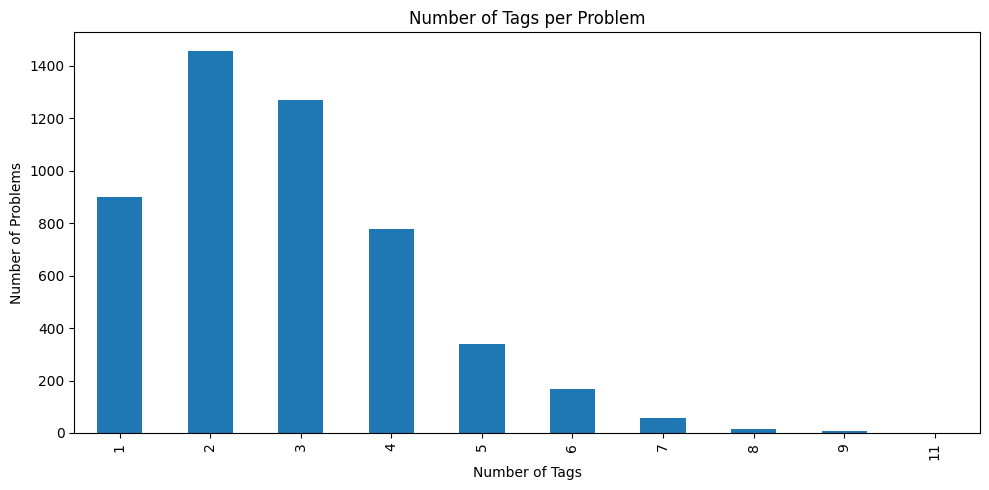

In [62]:
# Multi-label distribution
df['tags_list'] = df['tags'].str.split(', ')
all_tags = df['tags'].dropna().str.split(', ').explode()

print(f"Total samples: {len(df)}")
print(f"Samples with tags: {df['tags'].notna().sum()}")
print(f"Samples without tags: {df['tags'].isna().sum()}")
print(f"\nUnique tags: {all_tags.nunique()}")
print(f"Total tag occurrences: {len(all_tags)}")
print(f"Average tags per problem: {df['tags_list'].apply(lambda x: len(x) if x else 0).mean():.2f}")
print(f"Max tags per problem: {df['tags_list'].apply(lambda x: len(x) if x else 0).max()}")
print(f"Min tags per problem: {df['tags_list'].apply(lambda x: len(x) if x else 0).min()}")

tags_per_problem = df['tags_list'].apply(lambda x: len(x) if x else 0)
print("\nTags per problem distribution:")
print(tags_per_problem.value_counts().sort_index())

plt.figure(figsize=(10, 5))
tags_per_problem.value_counts().sort_index().plot(kind='bar')
plt.title('Number of Tags per Problem')
plt.xlabel('Number of Tags')
plt.ylabel('Number of Problems')
plt.tight_layout()
plt.show()


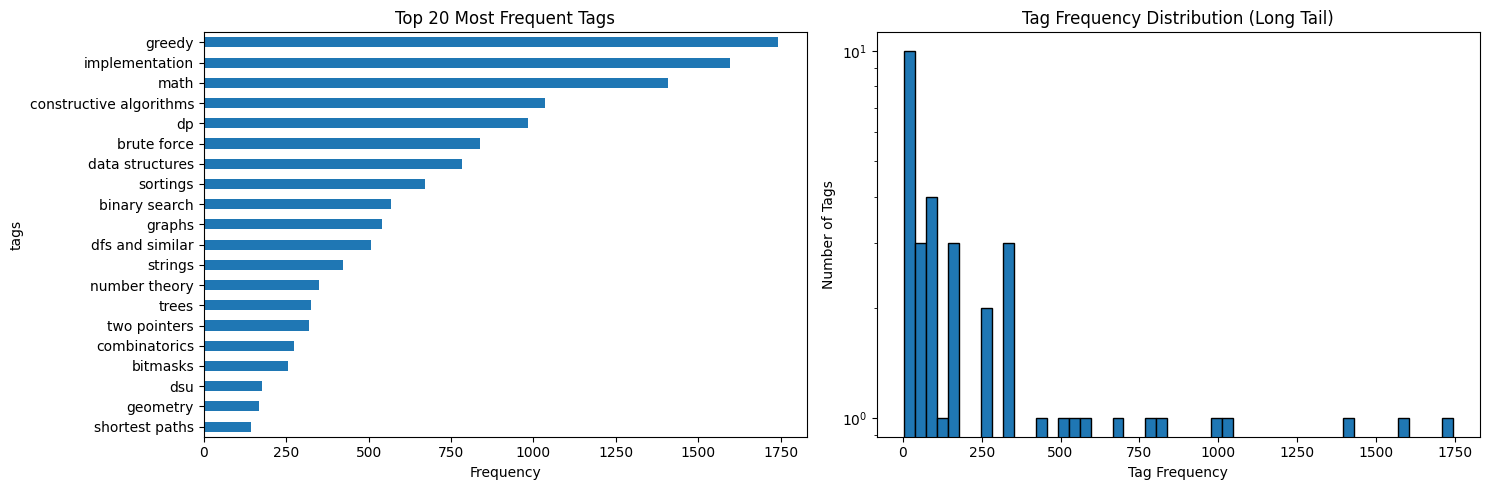

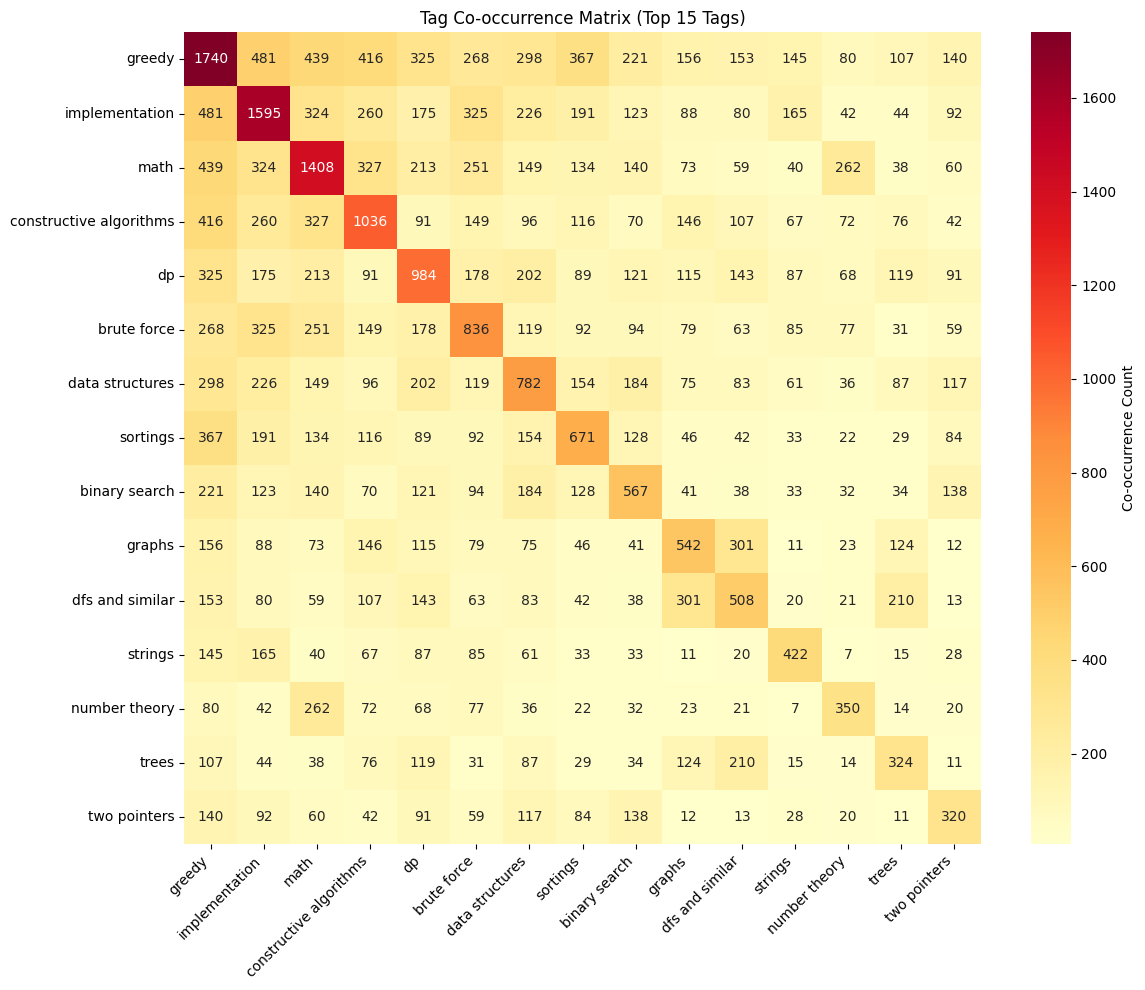

In [64]:
# Tag frequency analysis
tag_counts = all_tags.value_counts()


fig, axes = plt.subplots(1, 2, figsize=(15, 5))
tag_counts.head(20).plot(kind='barh', ax=axes[0])
axes[0].set_title('Top 20 Most Frequent Tags')
axes[0].set_xlabel('Frequency')
axes[0].invert_yaxis()
axes[1].hist(tag_counts.values, bins=50, edgecolor='black')
axes[1].set_xlabel('Tag Frequency')
axes[1].set_ylabel('Number of Tags')
axes[1].set_title('Tag Frequency Distribution (Long Tail)')
axes[1].set_yscale('log')
plt.tight_layout()
plt.show()


# Tag co-occurrence patterns
mlb = MultiLabelBinarizer()
tag_matrix = mlb.fit_transform(df['tags_list'].fillna('').apply(lambda x: x if x else []))
tag_names = mlb.classes_

top_n = 15
top_tags = tag_counts.head(top_n).index.tolist()
top_tag_indices = [list(tag_names).index(tag) for tag in top_tags]
cooccur = np.zeros((top_n, top_n))
for i, idx1 in enumerate(top_tag_indices):
    for j, idx2 in enumerate(top_tag_indices):
        cooccur[i, j] = (tag_matrix[:, idx1] & tag_matrix[:, idx2]).sum()
plt.figure(figsize=(12, 10))
sns.heatmap(cooccur, annot=True, fmt='.0f', xticklabels=top_tags,
            yticklabels=top_tags, cmap='YlOrRd', cbar_kws={'label': 'Co-occurrence Count'})
plt.title(f'Tag Co-occurrence Matrix (Top {top_n} Tags)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Observations from the EDA

Some observations from the eda : 
- There seems to be 16 rows with data and texte being in russian
- Columns we can drop : 
    * non-informative columns (unique value or almost unique) : "exec_outcome", "hidden_unit_tests" , "lang_cluster", "lang", "prob_desc_output_to", "prob_desc_input_from", "prob_desc_time_limit", "prob_desc_memory_limit",  "prob_desc_created_at", "lang"
    * Id columns : "src_uid", "code_uid", "file_name"
    * Metadata, irrelevant : "prob_desc_time_limit", "prob_desc_memory_limit", "prob_desc_created_at", "lang"
-  No missing data in the columns of interests (some missing data in "prob_desc_notes" and "difficulty" though which could be used as input for prediction, output and input formats are not always present as well), 





## 2. Data pre-processing

In [82]:
# Load data 
df = pd.read_parquet(OUTPUT_FILE)

# Preprocessing functions
import re 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess_with_tokens(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\$\$\$.*?\$\$\$', ' mathformulatoken ', text)
    text = re.sub(r'\b[a-z]_\w+\b', ' indexedvariabletoken ', text)
    text = re.sub(r'\b[a-zA-Z]\b', ' variabletoken ', text)
    text = re.sub(r'\b\d+\b', ' numbertoken ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    words = text.split()
    filtered_words = [word for word in words if len(word) > 2]
    return " ".join(filtered_words)



In [ ]:
id_columns = ["src_uid", "code_uid", "file_name"]
useless_columns = ["exec_outcome", "hidden_unit_tests", "lang_cluster", 
                   "prob_desc_output_to", "prob_desc_input_from"]
metadata_columns = ["prob_desc_time_limit", "prob_desc_memory_limit", 
                    "prob_desc_created_at", "lang"]

text_columns = ["prob_desc_description", "prob_desc_notes", 
                "prob_desc_input_spec", "prob_desc_output_spec", 
                "prob_desc_sample_inputs", "prob_desc_sample_outputs", 
                "source_code"]

#to_investigate = ["lang", "file_name", "difficulty", "tags"]
labels = ['math', 'graphs', 'strings', 'number theory', 'trees', 'geometry', 'games', 'probabilities']
feature_columns = ["prob_desc_description", "prob_desc_notes", "source_code", "difficulty"] 
target_columns = ["tags"]

all_columns = id_columns + useless_columns + metadata_columns + target_columns + text_columns

# Remove rows with russian language 
df = df[df.prob_desc_output_spec != "стандартный вывод"].copy()

# Keep only columns to use
df = df[feature_columns + target_columns].copy()
# Augment "prob_desc_description" with "prob_desc_notes" if present
df['prob_desc_notes'] = df['prob_desc_notes'].fillna('')  # Fill missing notes with empty string
df['prob_desc_description'] = df['prob_desc_description'] + ' ' + df['prob_desc_notes']
df.drop(columns=["prob_desc_notes"], inplace=True)
feature_columns = ["prob_desc_description", "source_code", "difficulty"] 

# Get only labels of interest  : 
df["tags_list"] = df["tags"].apply(lambda x : sorted([tag.strip() for tag in x.split(",") if tag.strip() in labels]))
df = df[df["tags_list"].str.len() > 0].reset_index(drop=True).copy()

# preprocess-text data : 
df['prob_desc_description'] = df['prob_desc_description'].apply(preprocess_with_tokens)

# Save 
#df.to_parquet(PREPROCESSED_OUTPUT_FILE, index=False)

# Load preprocessed data
df = pd.read_parquet(PREPROCESSED_OUTPUT_FILE)

            Missing  Percentage
difficulty       22    0.821509

prob_desc_description:
  Mean: 1254 | Median: 1182
  Min: 64 | Max: 4383
  Missing: 0

source_code:
  Mean: 1339 | Median: 743
  Min: 29 | Max: 58387
  Missing: 0


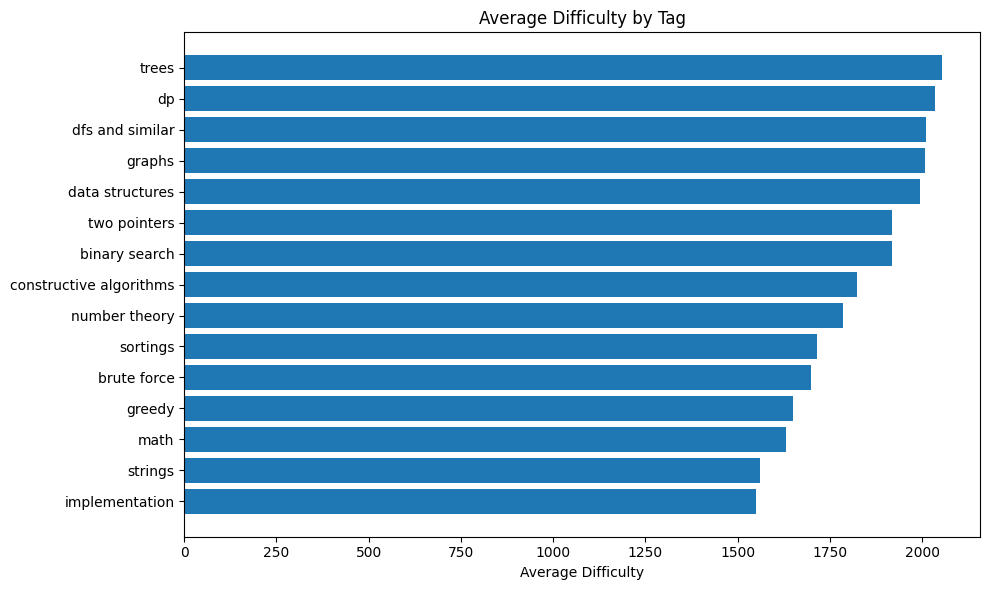

In [56]:
# Feature Analysis

# Missing values in features
missing = df[feature_columns].isnull().sum()
missing_pct = (missing / len(df) * 100)
missing_df = pd.DataFrame({
    'Missing': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)
print(missing_df[missing_df['Missing'] > 0])

# Text features length analysis
text_cols = ["prob_desc_description", "source_code"]
for col in text_cols:
    if col in df.columns:
        lengths = df[col].str.len()
        print(f"\n{col}:")
        print(f"  Mean: {lengths.mean():.0f} | Median: {lengths.median():.0f}")
        print(f"  Min: {lengths.min():.0f} | Max: {lengths.max():.0f}")
        print(f"  Missing: {df[col].isna().sum()}")

# Difficulty vs tags
tag_difficulty = []
for tag in tag_counts.head(15).index:
    mask = df['tags'].str.contains(tag, na=False)
    avg_diff = df[mask]['difficulty'].mean()
    tag_difficulty.append({'tag': tag, 'avg_difficulty': avg_diff, 'count': mask.sum()})
tag_diff_df = pd.DataFrame(tag_difficulty).sort_values('avg_difficulty', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(tag_diff_df['tag'], tag_diff_df['avg_difficulty'])
plt.xlabel('Average Difficulty')
plt.title('Average Difficulty by Tag')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [71]:
# Distribution of number of tags per problem
tags_per_problem = df['tags_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)
print(" Tags per problem:")
print(f"   - Mean: {tags_per_problem.mean():.2f}")
print(f"   - Median: {tags_per_problem.median():.0f}")
print(f"   - Min: {tags_per_problem.min():.0f}")
print(f"   - Max: {tags_per_problem.max():.0f}")


 Tags per problem:
   - Mean: 0.00
   - Median: 0
   - Min: 0
   - Max: 0


In [73]:
df.tags_list

0                [math]
1       [number theory]
2              [graphs]
3                [math]
4       [graphs, trees]
             ...       
2673          [strings]
2674          [strings]
2675             [math]
2676             [math]
2677           [graphs]
Name: tags_list, Length: 2678, dtype: object

#### Conclusion

Based on the analysis, we have : 

* Class Imbalance: A significant challenge is the severe class imbalance. The tag distribution has a long tail, with a few tags appearing very frequently and a large number of tags being quite rare. This suggests that strategies like using a weighted loss function or filtering out the rarest tags (like suggested in the problem description) might be necessary. Therefore, we will limit ourselves to the tags list given. This would significantly reduce the number of target classes, making the model easier to train.

* Potential Approaches: We will train a separate binary classifier for each tag. Number of samples seem too low for neural networks
* Feature Strategy:
    * For the text features, we will use methods like TF-IDF and more advanced embeddings could be effective.
    * For the source code, We will use specialized embeddings like CodeBERT  
    * The difficulty rating can be normalized and included as an additional numerical feature.
    * We won't do further feature enginnering for now although it could be useful (limited scope)


* Evaluation Metrics : Since this is a multi-label problem, standard accuracy is not sufficient. We will use : 
    * Classification Report: To show per-tag Precision, Recall, and F1-Score.
    * Macro-Averaged F1-Score: For a single score that evaluates performance across all tags equally.
    * Mean Average Precision (MAP) or Macro AUC: To measure the quality of the model's probability outputs.
    * Precision@K and Recall@K (e.g., K=3): To simulate a real-world use case by evaluating the top K suggested tags.
    * Jaccard Similarity (Intersection over Union): To measure the similarity between the sets of predicted and true labels for each sample.
    * Hamming Loss: For a simple and intuitive measure of the overall error rate.